event handling

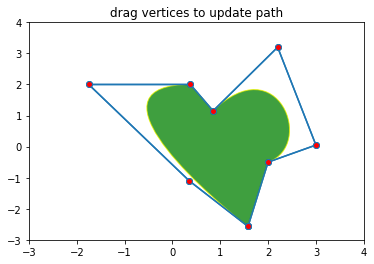

In [1]:
import numpy as np
from matplotlib.backend_bases import MouseButton
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

pathdata = [
    (Path.MOVETO, (1.58, -2.57)),
    (Path.CURVE4, (0.35, -1.1)),
    (Path.CURVE4, (-1.75, 2.0)),
    (Path.CURVE4, (0.375, 2.0)),
    (Path.LINETO, (0.85, 1.15)),
    (Path.CURVE4, (2.2, 3.2)),
    (Path.CURVE4, (3, 0.05)),
    (Path.CURVE4, (2.0, -0.5)),
    (Path.CLOSEPOLY, (1.58, -2.57)),
]

codes, verts = zip(*pathdata)
path = Path(verts, codes)
patch = PathPatch(
    path, facecolor='green', edgecolor='yellow', alpha=0.5)
ax.add_patch(patch)


class PathInteractor:
    """
    An path editor.

    Press 't' to toggle vertex markers on and off.  When vertex markers are on,
    they can be dragged with the mouse.
    """

    showverts = True
    epsilon = 5  # max pixel distance to count as a vertex hit

    def __init__(self, pathpatch):

        self.ax = pathpatch.axes
        canvas = self.ax.figure.canvas
        self.pathpatch = pathpatch
        self.pathpatch.set_animated(True)

        x, y = zip(*self.pathpatch.get_path().vertices)

        self.line, = ax.plot(
            x, y, marker='o', markerfacecolor='r', animated=True)

        self._ind = None  # the active vertex

        canvas.mpl_connect('draw_event', self.on_draw)
        canvas.mpl_connect('button_press_event', self.on_button_press)
        canvas.mpl_connect('key_press_event', self.on_key_press)
        canvas.mpl_connect('button_release_event', self.on_button_release)
        canvas.mpl_connect('motion_notify_event', self.on_mouse_move)
        self.canvas = canvas

    def get_ind_under_point(self, event):
        """
        Return the index of the point closest to the event position or *None*
        if no point is within ``self.epsilon`` to the event position.
        """
        # display coords
        xy = np.asarray(self.pathpatch.get_path().vertices)
        xyt = self.pathpatch.get_transform().transform(xy)
        xt, yt = xyt[:, 0], xyt[:, 1]
        d = np.sqrt((xt - event.x)**2 + (yt - event.y)**2)
        ind = d.argmin()

        if d[ind] >= self.epsilon:
            ind = None

        return ind

    def on_draw(self, event):
        """Callback for draws."""
        self.background = self.canvas.copy_from_bbox(self.ax.bbox)
        self.ax.draw_artist(self.pathpatch)
        self.ax.draw_artist(self.line)
        self.canvas.blit(self.ax.bbox)

    def on_button_press(self, event):
        """Callback for mouse button presses."""
        if (event.inaxes is None
                or event.button != MouseButton.LEFT
                or not self.showverts):
            return
        self._ind = self.get_ind_under_point(event)

    def on_button_release(self, event):
        """Callback for mouse button releases."""
        if (event.button != MouseButton.LEFT
                or not self.showverts):
            return
        self._ind = None

    def on_key_press(self, event):
        """Callback for key presses."""
        if not event.inaxes:
            return
        if event.key == 't':
            self.showverts = not self.showverts
            self.line.set_visible(self.showverts)
            if not self.showverts:
                self._ind = None
        self.canvas.draw()

    def on_mouse_move(self, event):
        """Callback for mouse movements."""
        if (self._ind is None
                or event.inaxes is None
                or event.button != MouseButton.LEFT
                or not self.showverts):
            return

        vertices = self.pathpatch.get_path().vertices

        vertices[self._ind] = event.xdata, event.ydata
        self.line.set_data(zip(*vertices))

        self.canvas.restore_region(self.background)
        self.ax.draw_artist(self.pathpatch)
        self.ax.draw_artist(self.line)
        self.canvas.blit(self.ax.bbox)


interactor = PathInteractor(patch)
ax.set_title('drag vertices to update path')
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 4)

plt.show()